In [2]:
pip install numpy pandas yfinance matplotlib seaborn scikit-learn tensorflow keras statsmodels plotly streamlit


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import yfinance as yf
import pandas as pd

ticker = "AAPL"  # Change to your preferred stock
start_date = "2015-01-01"
end_date = "2024-01-01"

df = yf.download(ticker, start=start_date, end=end_date)
df.to_csv("stock_data.csv")  # Save as CSV




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
print(df.head())  # View first few rows

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.320433  24.789802  23.879981  24.778679  212818400
2015-01-05  23.635294  24.169174  23.448437  24.089092  257142000
2015-01-06  23.637512  23.897778  23.274918  23.699798  263188400
2015-01-07  23.968964  24.069065  23.735391  23.846616  160423600
2015-01-08  24.889902  24.947740  24.180287  24.298187  237458000


In [5]:
import pandas as pd

df = pd.read_csv("stock_data.csv", skiprows=2)
df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.set_index('Date', inplace=True)
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].apply(pd.to_numeric, errors='coerce')

df.dropna(inplace=True)
print(df.head())
print(df.dtypes)


                 Open       High        Low      Close     Volume
Date                                                             
2015-01-02  24.320433  24.789802  23.879981  24.778679  212818400
2015-01-05  23.635294  24.169174  23.448437  24.089092  257142000
2015-01-06  23.637512  23.897778  23.274918  23.699798  263188400
2015-01-07  23.968964  24.069065  23.735391  23.846616  160423600
2015-01-08  24.889902  24.947740  24.180287  24.298187  237458000
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)


In [7]:
import numpy as np
train_size = int(len(df_scaled) * 0.8)
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size:]

print(f"Training Data Shape: {train_data.shape}")
print(f"Testing Data Shape: {test_data.shape}")


Training Data Shape: (1811, 5)
Testing Data Shape: (453, 5)


In [8]:
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])  # Last 60 days
        y.append(data[i, 0])  # Next day
    return np.array(X), np.array(y)
time_steps = 60
X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Training Sequences: {X_train.shape}")
print(f"Testing Sequences: {X_test.shape}")


Training Sequences: (1751, 60, 1)
Testing Sequences: (393, 60, 1)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


C:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.0239 - val_loss: 0.0015
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 9.2124e-04 - val_loss: 0.0015
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 12/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss

In [11]:
predictions = model.predict(X_test)
print("Predictions Shape:", predictions.shape)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step 
Predictions Shape: (393, 1)


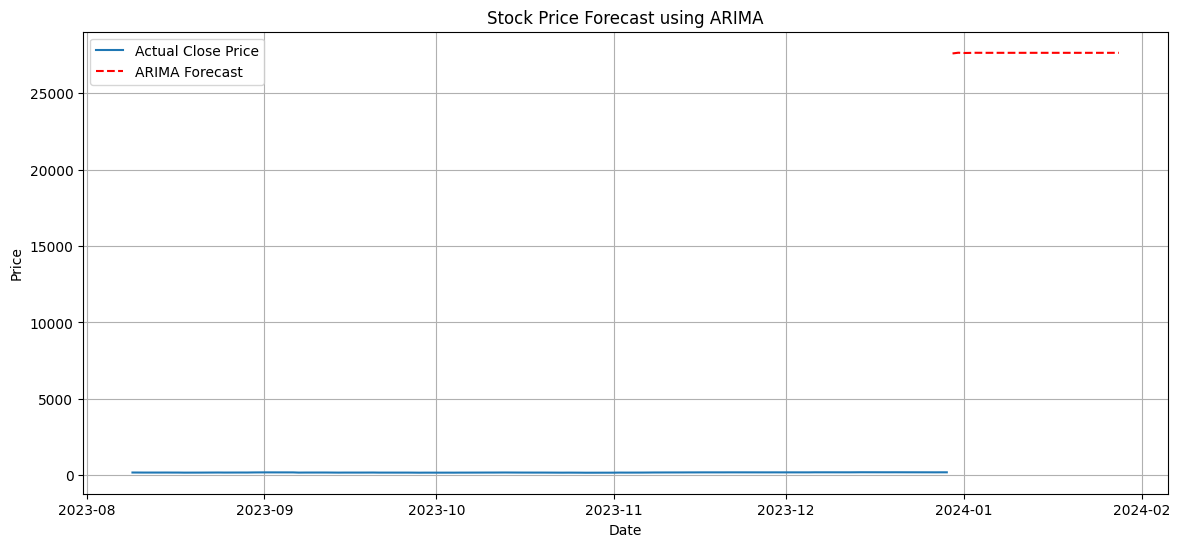

In [18]:
import matplotlib.pyplot as plt

# Combine ARIMA forecast with dates
forecast_series = pd.Series(forecast_rescaled.flatten(), index=future_dates)

# Plot actual vs ARIMA forecast
plt.figure(figsize=(14,6))
plt.plot(df.index[-100:], df["Close"].values[-100:], label="Actual Close Price")
plt.plot(forecast_series.index, forecast_series.values, label="ARIMA Forecast", linestyle='--', color='red')
plt.title("Stock Price Forecast using ARIMA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


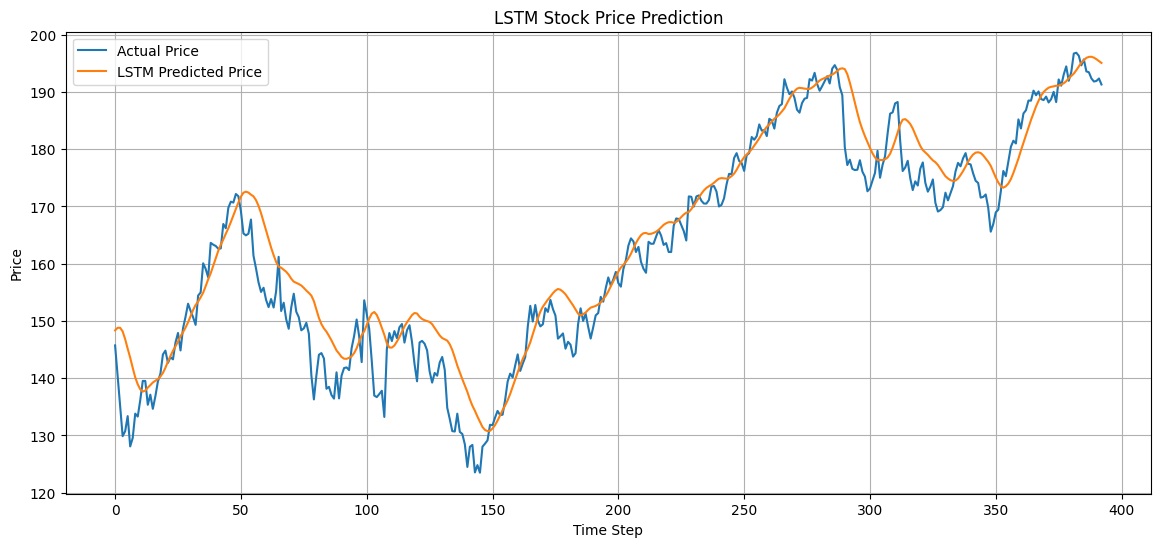

In [19]:

# Rescale LSTM predictions back to original scale
predicted_prices = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], df.shape[1] - 1)))))[:, 0]
real_prices = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], df.shape[1] - 1)))))[:, 0]

# Plot LSTM predictions vs actual
plt.figure(figsize=(14,6))
plt.plot(real_prices, label="Actual Price")
plt.plot(predicted_prices, label="LSTM Predicted Price")
plt.title("LSTM Stock Price Prediction")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
